In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("heart.csv")

X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

categorical_features = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer([
    ("numerical", StandardScaler(), numeric_features),
    ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = {}
conf_matrices = {}   # store confusion matrices

for name, model in models.items():

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)

    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    results[name] = acc
    conf_matrices[name] = cm

    print(f"\n========== {name} ==========")
    print("Accuracy:", acc)
    print(classification_report(y_test, predictions))

# Show results
results



========== Logistic Regression ==========
Accuracy: 0.8532608695652174
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184


========== Random Forest ==========
Accuracy: 0.8804347826086957
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        77
           1       0.90      0.89      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



{'Logistic Regression': 0.8532608695652174,
 'Random Forest': 0.8804347826086957}

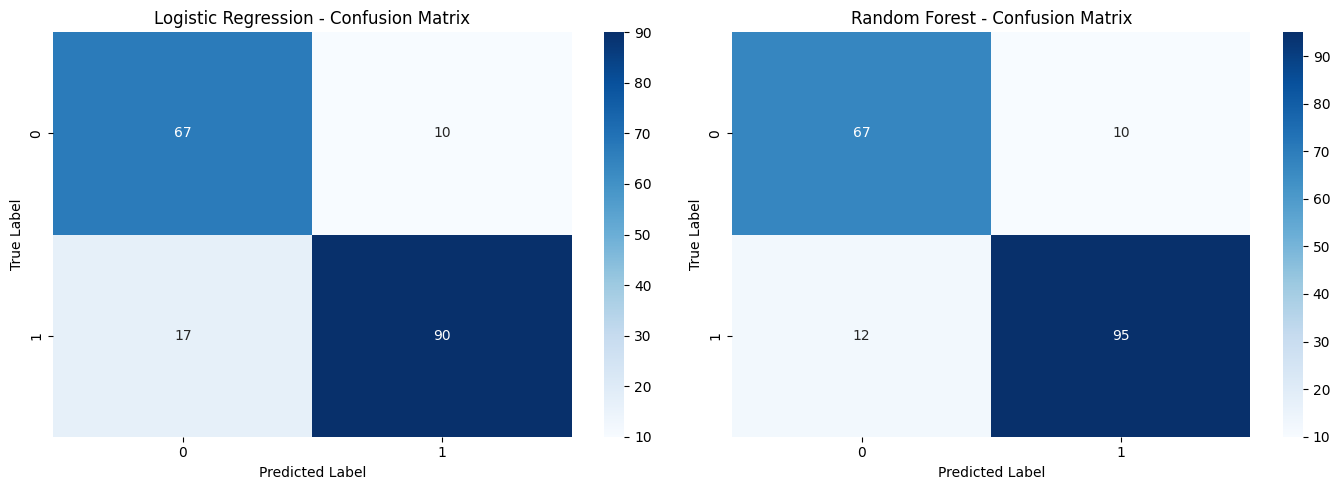

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", ax=ax)
    ax.set_title(f"{name} - Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


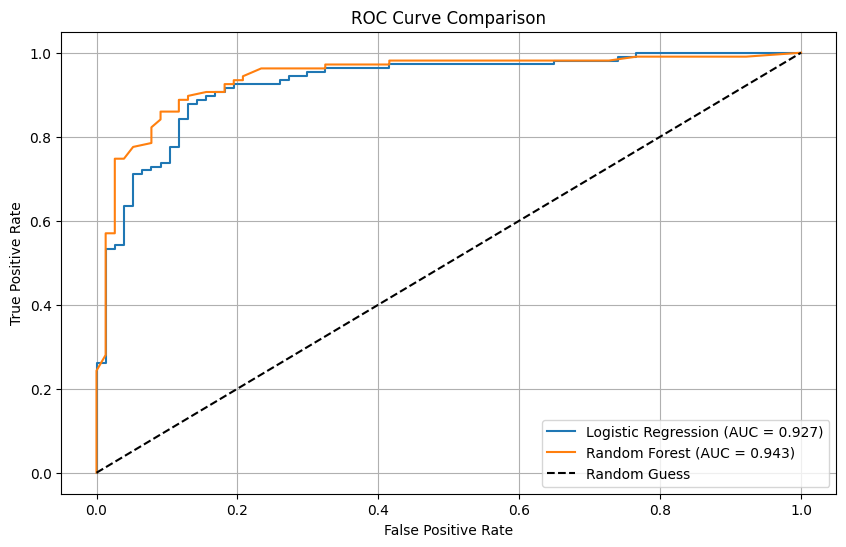

In [5]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 6))

for name, model in models.items():
    
    # Build pipeline again for probability output
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
    pipeline.fit(X_train, y_train)
    
    # Probability scores
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# Plot setup
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()
